# eScience Incubator Project: Data Analytics for Demixing and Decoding Patterns of Population Neural Activity Underlying Addiction Behavior 

### Charles Zhou, Research Scientist at the Center in Neurobiology of Addiction, Pain, and Emotion

The aim of this project is to apply novel statistical and machine learning analysis techniques to large-scale 2-photon calcium imaging data with respect to addiction-related behaviors and assays.



![alt text](fig1.jpg "Title")

In [1]:
# load dependencies
import h5py
import tensortools as tt # toolbox for TCA
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle # for loading behav data
import utils
import importlib as imp
import pandas as pd

import xarray # for organizing and storing the data 
import pandas as pd
from sklearn_xarray import wrap
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# 3d state space plot
from matplotlib.colors import ListedColormap, BoundaryNorm    
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import hypertools as hyp

import matplotlib
# important for text to be detecting when importing saved figures into illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

c:\users\stuberadmin\anaconda3\envs\escience_incubator\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# indicate a file to analyze
filename = 'VJ_OFCVTA_7_260_D6'
root_dir = 'C:\\2pData\\Vijay data\\VJ_OFCVTA_7_D8_trained\\'
sima_h5_path = root_dir + filename + '_sima_mc.h5'

# set the sampling rate
fs = 5

### Understanding and preprocessing the data

The data are in h5 (HDF5) format, which has the advantage of being able to load portions of the data into memory at a time. Below, we load the data, reorganize the dimensions, and convert it into x-array format. X-array is a python-unique data structure that allows for storage of meta-data.

In [3]:
data_snip = utils.load_h5(sima_h5_path)
data_snip.shape

(499, 490, 15169)

In [4]:
# calculate some meta data

data_dims = data_snip.shape
tvec = np.linspace(0, data_dims[2]/fs, data_dims[2])

In [5]:
# let's plot the first frame from the video snippit
frame_num = 0
to_plot = data_snip[:,:,frame_num]

utils.plot_single_img(to_plot, frame_num) # function in custom code utils

### Let's take a look at the behavioral data.

During the brain recordings, animals perform a behavioral task (pavlovian conditioning) that allows for understanding how neural activity gives rise to memory encoding of rewards. The significance of examining this behavior is that addiction states are heavily based on associating a drug (unconditioned stimulus - US) to a particular cue (eg. heroin needle; conditioned stimulus - CS).

The figure below (Namboodiri et al., 2019 Nature Neuroscience) shows the recording setup and task:

![alt text](namboodiri_nn_fig1ab.png "Title")


We ultimately want to reshape the data for a certain session (typically y_pixels, x_pixels, time/samples) to be amenable to trial-by-trial classifcation in a neural network. The resulting reshaped dimensions will be: trial, y_pixels, x_pixels, time/samples. So for a session with two behavioral conditions 50 trials each, 512x512, and 3 second trials (at 5 hz, that's 15 samples), our resulting array/tensor will be: 100 x 512 x 512 x 15. 

Since we have orders of magnitude more values for x and y pixels than samples, we will ultimately be performing dimensionality reduction to make the dataset more tractable. We will perform dimensionality reduction across y_pixels, x_pixels, and time/samples.

In [6]:
# trial windowing 
trial_window = np.array([-1, 3]) # in seconds relative to ttl-onset/trial-onset

In [7]:
#load behavioral data and trial info
glob_frame_files = glob.glob(root_dir + "framenumberforevents*") # look for a file in specified directory
frame_events = pickle.load( open( glob_frame_files[0], "rb" ), encoding="latin1" ) # latin1 b/c original pickle made in python 2

### Raw behavioral data organization

Across the whole recording session, the animal is presented with randomized stimuli paired with or without sucrose rewards (each presentation is considered a trial). 

The time (ie. sample) at which each trial occurs relative to the beginning of the session is recorded.



In [8]:
# if helper scripts have been updated, can refresh them with this line
imp.reload(utils)

<module 'utils' from 'C:\\Users\\stuberadmin\\Documents\\GitHub\\nape_tca_nn\\utils.py'>

In [9]:
trial_window_samp = trial_window*fs # turn trial start/end times to samples

conditions = ['minus', 'plus_rewarded']

data_dict= utils.extract_trial_data(data_snip, trial_window_samp[0], trial_window_samp[1],
                                                       frame_events, conditions)

## Turn trial-extracted data to xarray

In [10]:
"""let's load data into xarray format, which has numerous 
advantages over using numpy arrays, one of which is the ability 
to assign names to dimensions rather than indexing by ints """

num_avg_groups = 5.0 
""" number of segments to split trials over. Ie. Because single trial plots in state space is noisy, 
    let's break the trials up into groups and average to get less noisier signal.
""" 

for condition in conditions:
    
    ypix_vec = range(0,data_dims[0])
    xpix_vec = range(0,data_dims[1])
    flattenpix_vec = range(0,data_dims[0]*data_dims[1])
    trials_vec = range(data_dict[condition]['num_trials'])
    trial_tvec = np.linspace(trial_window[0], trial_window[1], data_dict[condition]['num_samples'])

    # xarray with dims: x,y,trial,samples
    data_dict[condition]['xarr_data'] = xarray.DataArray(data_dict[condition]['data'], coords=[trials_vec, ypix_vec, xpix_vec, trial_tvec], dims=['trial', 'y', 'x', 'time'])

    # flatten x and y pixels into one dimension
    # reshape data and make xarray with dims: x-y,trial,samples
    flatten_pix_trial_data = np.reshape(data_dict[condition]['data'], (len(trials_vec), data_dims[0]*data_dims[1], len(trial_tvec)))
    data_dict[condition]['xarr_flatten_xy'] = xarray.DataArray( flatten_pix_trial_data, # this flattens only the x,y dimensions
                                       coords=[trials_vec, flattenpix_vec, trial_tvec], 
                                       dims=['trial', 'yx', 'time'])
    
    # average across trials
    data_dict[condition]['xarr_flatten_pix_trialAvg'] = data_dict[condition]['xarr_flatten_xy'].mean(dim = 'trial')
    
    ### https://stackoverflow.com/questions/43015638/xarray-reshape-data-split-dimension
    # unstack trials into groups and average across trials (avged trials grouped by time)
    
    num_trials_to_avg = data_dict[condition]['num_trials']/num_avg_groups

    ind = pd.MultiIndex.from_product([np.arange(0, num_trials_to_avg), np.arange(0, num_avg_groups)],
                                     names=['trials', 'trial_groups'])[np.arange(0, data_dict[condition]['num_trials'])] 
    # last arange cuts the index list if the number of trials per group does divide evenly into total num trials

    data_dict[condition]['xarr_flatten_xy_group_trials'] = data_dict[condition]['xarr_flatten_xy'].assign_coords(trial=ind).unstack('trial').mean(dim = 'trials').transpose('trial_groups', 'yx', 'time')
    ###
    
# pull out all trial-avged data for each cond, then average across conditions
data_dict['all_cond'] = {}
data_dict['all_cond']['flattenpix_trial_cond_avg'] = np.average( [data_dict[condition]['xarr_flatten_pix_trialAvg'].data 
                                       for condition in conditions], axis=0)

# Perform PCA Dimensionality Reduction Across Pixels

In [11]:
# perform PCA
variance_thresh = 0.9
pca_xr_wrapper = wrap(PCA(variance_thresh), reshapes='yx', random_state=5) # create PCA object and specify dimension to perform PCA on

# fit PCA on trial and condition-averaged data; final dims are pixels by time
data_dict['all_cond']['Xt'] = pca_xr_wrapper.fit_transform( data_dict['all_cond']['flattenpix_trial_cond_avg'].transpose() )

for condition in conditions:
    
    data_dict[condition]['Xt'] = pca_xr_wrapper.transform(data_dict[condition]['xarr_flatten_pix_trialAvg'].transpose())
    
    data_dict[condition]['pca_explained_var_perc'] = pca_xr_wrapper.estimator_.explained_variance_ratio_*100


num_comps = pca_xr_wrapper.estimator_.n_components_

In [25]:
fig_save_dir

'C:\\Users\\stuberadmin\\Dropbox (Stuber Lab)\\Charles\\illustrator\\20200216_jUpdate_PCA\\'

<IPython.core.display.Javascript object>


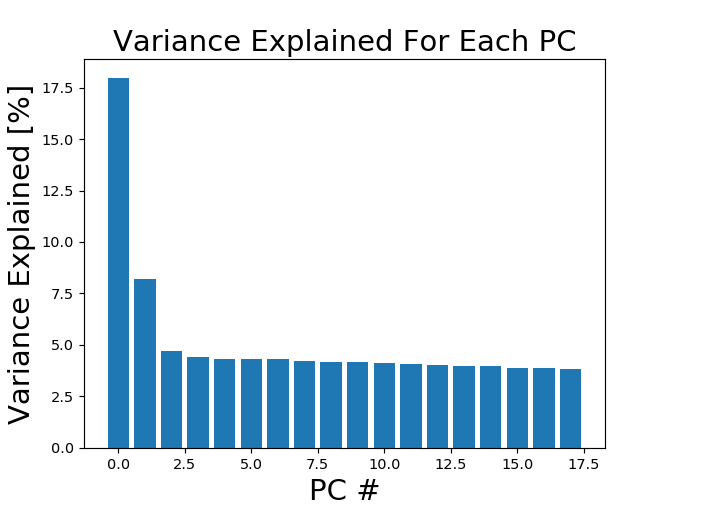

In [26]:
fig, ax = plt.subplots()
x_ticks = range(0,num_comps)
ax.bar(x_ticks, data_dict[condition]['pca_explained_var_perc'])
ax.set_title('Variance Explained For Each PC', fontsize = 20)
ax.set_ylabel('Variance Explained [%]', fontsize = 20)
ax.set_xlabel('PC #', fontsize = 20);

mpld3.save_html(fig, fig_save_dir + 'state_space_trial_group.html', template_type='simple')

<IPython.core.display.Javascript object>


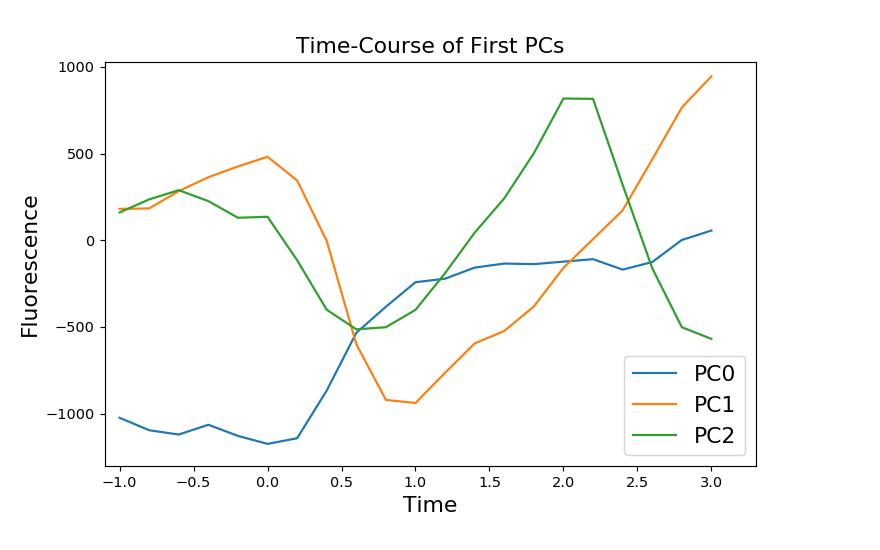

In [27]:
plt.figure(figsize = (8,5))
plt.plot(trial_tvec, data_dict['minus']['Xt'][:,:3])
plt.title('Time-Course of First PCs', fontsize = 15)
plt.ylabel('Fluorescence', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.legend(['PC0', 'PC1', 'PC2'], fontsize = 15);

In [14]:
# transform individual trial data into trial-avg PC space

for condition in conditions:

    trial_data = data_dict[condition]['xarr_flatten_xy_group_trials']
    num_trials = trial_data.shape[0]
    
    trial_nparray = np.empty([num_trials, data_dict[condition]['num_samples'], num_comps])
    
    for idx, trial_dat in enumerate(trial_data):
        
        trial_nparray[idx,:,:] = pca_xr_wrapper.transform(trial_dat.transpose())
    
    data_dict[condition]['Xt_trial'] = trial_nparray

In [15]:
# compares list of old limits to new limits; replaces limits if new limits are outside of old
def update_lims(new_lims, old_lims = None):
    
    updated_lims = np.empty_like(new_lims)
    
    for min_max in [0, 1]: # indices where 0 for min, 1 for max
        
        if old_lims is None:
            updated_lims[min_max] = new_lims[min_max]
        else:
            compare = [old_lims[min_max], new_lims[min_max]]
            updated_lims[min_max] = compare[np.argmax(np.abs(compare))]

    return updated_lims

In [16]:
class plot_3d_state_space():
    
    def __init__(self, x, y, z):
        
        return self

In [17]:
def make_line_collection(x, y, z, color_encode, cmap, trial = False, alpha = 1.0):

    # Create a set of line segments
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the 3D-line collection object
    lc = Line3DCollection(segments, cmap=plt.get_cmap(cmap),
                        norm=plt.Normalize(np.min(color_encode), np.max(color_encode))) # set LUT for segment colors
    lc.set_array(color_encode) # set the dimension and values for color encoding
    
    
    # all trial averaged lines will have markers
    if trial == False:
        lc.set_linestyle(':')
        lc.set_linewidth(4)
        
    # trial group lines should encode segment number in alpha
    if trial == True:
        lc.set_alpha(alpha)
        lc.set_linewidth(1.5)
        
    return lc

In [18]:

#for idx_condition, condition in enumerate(conditions):
#hyp.plot(data_dict[condition]['Xt'][:3].transpose(), animate = True, bullettime = True, save_path = 'Downloads')

<IPython.core.display.Javascript object>


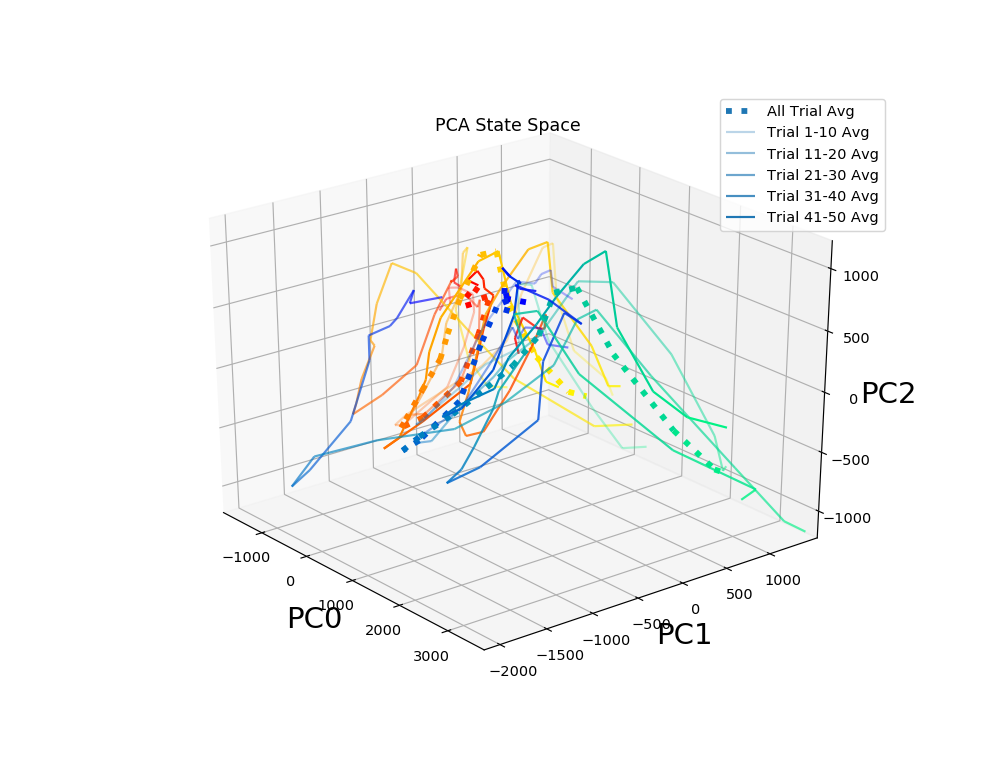

In [29]:
%matplotlib notebook

# container to store data relevant to the 3d plot
s_space_dict = {}
s_space_dict['line_cmaps'] = ['autumn','winter']

# determine alpha for each trial (encoding time block)
trial_group_alphas = np.linspace(0.3, 1, num_avg_groups)

# loop through conditions
for idx_condition, condition in enumerate(conditions):

    # set up variables for this condition
    s_space_dict[condition] = {} # sub-dict for condition-specific data 
    n = data_dict[condition]['num_samples'] # number of data points
    cmap_lc = s_space_dict['line_cmaps'][idx_condition] # grab this condition's line cmap
    
    #set x,y,z, time data
    x = data_dict[condition]['Xt'][:,0]
    y = data_dict[condition]['Xt'][:,1]
    z = data_dict[condition]['Xt'][:,2]
    svec = np.arange(0,n) # sample vector; important for encoding color as time
    # USER DEFINE: which dimension to encode color; can be x, y, z, svec
    color_encode = svec 
    
    # update x,y,z limits based on this condition's data
    if idx_condition == 0:
        xlim = [np.min(x), np.max(x)]; ylim = [np.min(y), np.max(y)]; zlim = [np.min(z), np.max(z)]
    else:
        xlim = update_lims([np.min(x), np.max(x)], xlim); 
        ylim = update_lims([np.min(y), np.max(y)], ylim);
        zlim = update_lims([np.min(z), np.max(z)], zlim);
    
    ### Create line segment objects for ALL TRIAL-AVGED DATA ###
    s_space_dict[condition]['line_collect'] = make_line_collection(x, y, z, color_encode, cmap_lc)
    
    ### Create line segment objects for TRIAL-BLOCKED/GROUPED DATA ###
    s_space_dict[condition]['line_collect_trial'] = {}
    for idx, trial in enumerate(data_dict[condition]['Xt_trial']):
        
        # make the line segment object for this trial group
        s_space_dict[condition]['line_collect_trial'][idx] = make_line_collection(trial[:,0], trial[:,1], trial[:,2], 
                                                                                  color_encode, 
                                                                                  cmap_lc, 
                                                                                  trial = True, 
                                                                                  alpha = trial_group_alphas[idx])

        # update x,y,z limits based on this "trial's" data
        xlim = update_lims([np.min(trial[:,0]), np.max(trial[:,0])], xlim); 
        ylim = update_lims([np.min(trial[:,1]), np.max(trial[:,1])], ylim);
        zlim = update_lims([np.min(trial[:,2]), np.max(trial[:,2])], zlim);
        
# create plot and set attributes
fig = plt.figure(figsize = (9,7))
ax = fig.gca(projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.title('PCA State Space')
ax.set_xlabel('PC0', fontsize = 20); ax.set_ylabel('PC1', fontsize = 20); ax.set_zlabel('PC2', fontsize = 20);

# plot the line segments
for condition in conditions:
    
    # for all trial-avged data
    ax.add_collection3d(s_space_dict[condition]['line_collect'], zs=z, zdir='z')

    # for trial group data
    for trial_lc in s_space_dict[condition]['line_collect_trial'].values():
        
        ax.add_collection3d(trial_lc, zs=z, zdir='z')
        
ax.legend(['All Trial Avg','Trial 1-10 Avg','Trial 11-20 Avg',
           'Trial 21-30 Avg','Trial 31-40 Avg','Trial 41-50 Avg']);

# save plot
fig_save_dir = 'C:\\Users\\stuberadmin\\Dropbox (Stuber Lab)\\Charles\\illustrator\\20200216_jUpdate_PCA\\'
#matplotlib.pyplot.savefig(fig_save_dir + 'state_space_trial_group.pdf')

#mpld3.save_html(fig, fig_save_dir + 'state_space_trial_group.html', template_type='simple')

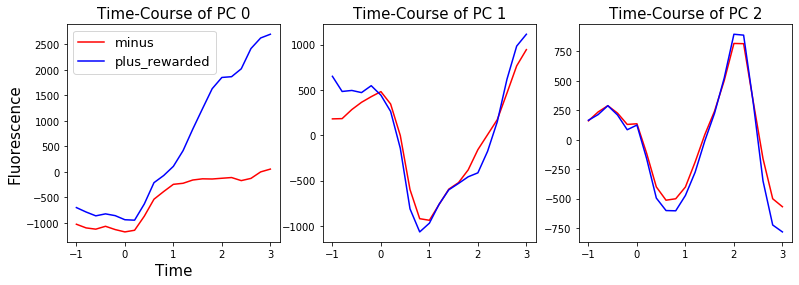

In [53]:
%matplotlib inline

from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='rb')

fig, ax = plt.subplots(1, 3, figsize = (13,4))

for iPC in range(3):
   
    for condition in conditions:
        ax[iPC].plot(trial_tvec, data_dict[condition]['Xt'][:,iPC])
        ax[iPC].set_title(f'Time-Course of PC {iPC}', fontsize = 15)
        if iPC == 0:
            ax[iPC].set_ylabel('Fluorescence', fontsize = 15)
            ax[iPC].set_xlabel('Time', fontsize = 15)
            ax[iPC].legend(conditions, fontsize = 13);

### Let's check out the PCA estimator attributes

In [51]:
# function to make a figure with subplots of heatmaps
def plot_img_vectorized_component(n_columns, data):
    
    clims = [np.min(data), np.max(data)]
    
    num_comps = data.shape[0]
    n_rows = int(np.ceil(num_comps/n_columns))
   
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_columns, figsize = (15, n_rows*4))
    for iComp in range(num_comps):
        
        if n_rows == 1:
            subplot_index = iComp
        else:
            subplot_index = np.unravel_index(iComp, (n_rows, n_columns)) # turn int index to a tuple of array coordinates
        
        title = f"PC {iComp}"
        pc_pixel_weights = data[iComp,:].reshape(data_dims[0],data_dims[1])

        im = utils.subplot_heatmap(ax[subplot_index], title, pc_pixel_weights, clims = clims)
     
    fig.colorbar(im, ax = ax, shrink = 0.5)

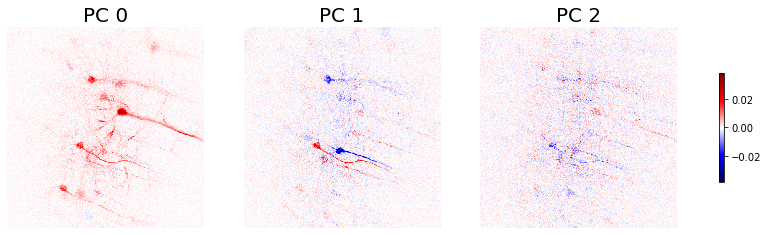

In [52]:
# For each PC, plot the eigenvectors: weights/contribution of each pixel

# makes plot non-interactable
%matplotlib inline

n_columns = 3
plot_img_vectorized_component(n_columns, pca_xr_wrapper.estimator_.components_[:3])


## How do the reconstructed activity maps look at the beginning and end of each condition for specific PCs?

In [58]:
def time_to_samples(trial_tvec, analysis_window, fs):
    
    """Takes in a numpy 2d array and a subplot location, and plots a heatmap at the subplot location without axes

    Parameters
    ----------
    trial_tvec : np 1d vector 
        Vector of times in seconds that correspond to the samples in the data

    analysis_window : np 1d vector , entries are floats
        First entry is the window start time in seconds, second entry is the window end time
        in seconds.

    fs : float
        Sampling rate in Hz

    Returns
    -------
    analysis_svec : np 1d vector 
        Vector of samples that are the corresponding samples in the trial_tvec between the start and end times 

    """

    analysis_win_start_samp = np.argmin(abs(trial_tvec - analysis_window[0]))
    analysis_win_end_samp = np.argmin(abs(trial_tvec - analysis_window[1]))
    
    analysis_svec = np.arange(analysis_win_start_samp, analysis_win_end_samp)
    
    return analysis_svec

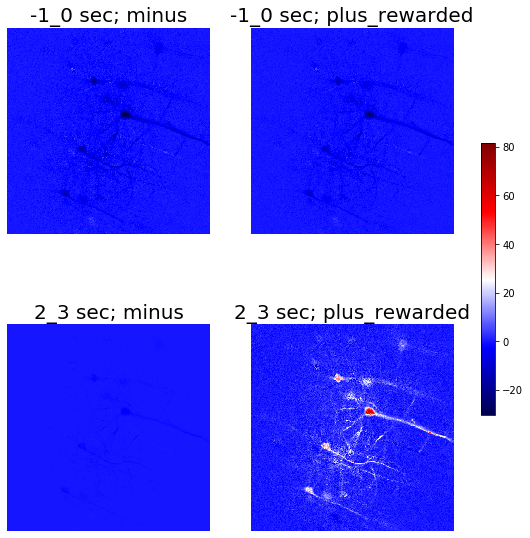

In [59]:
analysis_windows = np.array([[-1, 0], [2, 3]])
num_PCs = 1

recon_map = {}

for idx_window, analysis_window in enumerate(analysis_windows):

    analysis_window_str = f"{analysis_window[0]}_{analysis_window[1]}"
    recon_map[analysis_window_str] = {}

    for idx_cond, condition in enumerate(conditions):

        data_PC = data_dict[condition]['Xt'][time_to_samples(trial_tvec, analysis_window, fs),:num_PCs]

        eigenvector_PC = pca_xr_wrapper.estimator_.components_[:num_PCs,:]

        recon_map[analysis_window_str][condition] = np.mean(np.matmul(data_PC,eigenvector_PC), axis=0).reshape(data_dims[0],data_dims[1])

        if idx_window == 0 & idx_cond == 0:
            recon_map['clims'] = update_lims([np.min(recon_map[analysis_window_str][condition]), np.max(recon_map[analysis_window_str][condition])])
        else:
            recon_map['clims'] = update_lims([np.min(recon_map[analysis_window_str][condition]), np.max(recon_map[analysis_window_str][condition])], recon_map['clims'])

fig, axs = plt.subplots(2,2, figsize = (10,10))
for idx_window, analysis_window in enumerate(analysis_windows):
    
    analysis_window_str = f"{analysis_window[0]}_{analysis_window[1]}"
    
    for idx_cond, condition in enumerate(conditions):
        title = f"{analysis_window_str} sec; {condition}"
        im = utils.subplot_heatmap(axs[idx_window, idx_cond], title, recon_map[analysis_window_str][condition], clims = recon_map['clims'])

fig.colorbar(im, ax = axs, shrink = 0.5)

# TCA

In [ ]:
# Make synthetic dataset.
I = len(data_dict[condition]['xarr_flatten_xy'].yx)
J, K = data_dims[0], data_dims[1]
R = 3 # dimensions/rank
# R is number of components

X = data_dict[condition]['xarr_flatten_xy'].data
#dims are (yx_pix, trial, time)

In [ ]:
# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)

# Compare the low-dimensional factors from the two fits.
fig, _, _ = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Show plots.
plt.show()

In [ ]:
pixel_factor = 0
n_columns = 4

plot_img_vectorized_component(n_columns, np.transpose(V.factors[pixel_factor]))

In [ ]:


tseries = V.factors[2][:,component]
plt.figure()
plt.plot(trial_tvec, tseries)